# Metrics & Fine-tunning
主要涉及近义词阈值、排序权重&Hit相关参数的确定，主要基于对数据的可视化与探索实现

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import Binarizer

import src.poem.constant as c

正在读取数据...
数据读取完成


## 近义词阈值确定
首先对相似矩阵中的值作可视化，查看一下大致分布。由于大部分因为完全正交是0，因此只可视化了所有非0值：

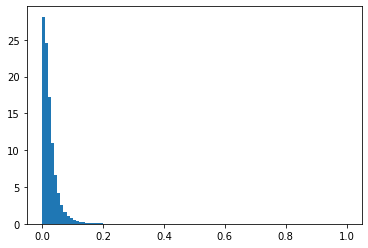

In [2]:
import matplotlib.pyplot as plt
plt.hist(c.sim.data, density=True, bins=100)
plt.show()

确认一下非零值的比例，不到2%：

In [3]:
c.sim

<19846x19846 sparse matrix of type '<class 'numpy.float64'>'
	with 6724949 stored elements in Compressed Sparse Row format>

In [4]:
6724949 / (19846 * 19846)

0.017074304453066198

**准则**：被判定为近义词时，应使得包含相同字的词对比例尽可能高

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


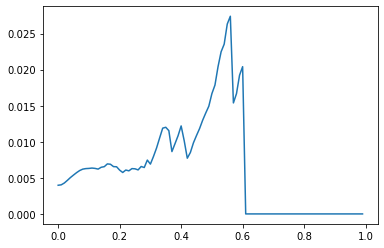

In [5]:
from src.poem.query import judge_same_word
from tqdm import tqdm

thres_list = np.arange(0, 1, 0.01)
ratio = []
totals = []
comms = []

for thres in tqdm(thres_list):
    thresed = c.sim.copy()
    thresed = Binarizer(threshold=thres).transform(thresed)

    comm = 0
    total = 0
    for i, j in zip(*thresed.nonzero()):
        if i > j:
            total += 1
            if judge_same_word(c.word_dictr[i], c.word_dictr[j]):
                comm += 1
    r = 0
    if total > 0:
        r = comm / total
    ratio.append(r)
    totals.append(total)
    comms.append(comm)
plt.plot(thres_list, ratio)

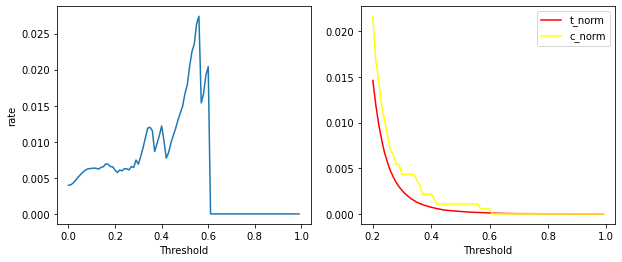

In [12]:
totals = np.array(totals)
comms = np.array(comms)
ratio = np.array(ratio)

t_norm = totals / np.std(totals)
c_norm = comms / np.std(comms)
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(thres_list, ratio)
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.subplot(1, 2, 2)
plt.xlabel('Threshold')
plt.plot(thres_list[20:],t_norm[20:],label="t_norm",color="red")
plt.plot(thres_list[20:],c_norm[20:],label="c_norm",color="yellow")

plt.legend(loc="upper right")

plt.show()

In [14]:
index = np.argmax(ratio[:38])
thres_list[index]

0.35000000000000003

In [15]:
cc, ci = 0, 0

sym_list = list(c.sym_set)
for i in range(len(sym_list)):
    for j in range(i + 1, len(sym_list)):
        if judge_same_word(sym_list[i], sym_list[j]):
            cc += 1
        else:
            ci += 1
ci, cc

(3466939, 13902)

In [22]:
ci / cc

249.38418932527694

In [24]:
np.mean(comms[:50] / (totals[:50] - comms[:50])) * (ci / cc)

1.9716986164385752

In [27]:
pair_num = (totals[35] - comms[35])*1.9716986164385752
pair_num, comms[comms >= pair_num]

(1135.6984030686194,
 array([13355,  9741,  6801,  4702,  3246,  2254,  1594,  1149]))

In [28]:
comms[:10]

array([13355,  9741,  6801,  4702,  3246,  2254,  1594,  1149,   838,
         614])

In [36]:
thres = 0.069

thresed = c.sim.copy()
thresed = Binarizer(threshold=thres).transform(thresed)

comm = 0
for i, j in zip(*thresed.nonzero()):
    if i > j and judge_same_word(c.word_dictr[i], c.word_dictr[j]):
        comm += 1

comm

1183

由上选定两个阈值：0.35和0.07

## 加权与Hit
在报告中论证过，hit算法应当是权值一致的情况下作为第二关键字排序，下说明加权的权值来源：

前一个level与后一个level相差约10倍

In [28]:
from tqdm import trange

sim_cnt_avg = [0]

for i in trange(len(sym_list)):
    if sim_cnt_avg[-1] > 0:
        sim_cnt_avg.append(0)
    for j in range(i + 1, len(sym_list)):
        val = c.sim[i, j]
        if val < 0.07:
            continue
        is_same = judge_same_word(sym_list[i], sym_list[j])
        if (is_same and val >= 0.07) or ((not is_same) and val >= 0.35):
            sim_cnt_avg[-1] += 1
sim_cnt_avg = np.array(sim_cnt_avg)
np.mean(sim_cnt_avg[sim_cnt_avg > 0])

100%|██████████████████████████████████████████████████████████████████████████████| 2639/2639 [01:23<00:00, 31.74it/s]


1.5

In [48]:
from tqdm import trange

sim_avg = []
sim_avg2 = []

for i in trange(len(sym_list)):
    for j in range(i + 1, len(sym_list)):
        is_same = judge_same_word(sym_list[i], sym_list[j])
        val = c.sim[i, j]
        if is_same and val >= 0.07:
            sim_avg.append(val)
        elif (not is_same) and val >= 0.35:
            sim_avg2.append(val)
            
np.mean(sim_avg), np.mean(sim_avg2)

100%|██████████████████████████████████████████████████████████████████████████████| 2639/2639 [01:37<00:00, 26.95it/s]


(0.11309679094428852, 0.44390500631836005)

## Hit

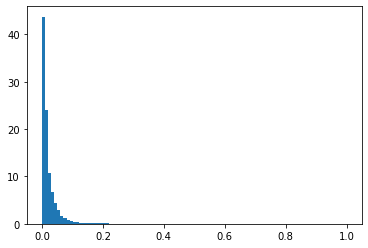

In [41]:
plt.hist(c.poem_sim.data, density=True, bins=100)
plt.show()